In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from evaluate_flipflop import get_base_accuracy, get_digit_accuracy, get_relaxed_distance_accuracy, get_strict_distance_accuracy, get_per_dist_accuracy

In [112]:
llama_res = 'llama3.1_70B'
olmo_res = 'OLMo_7B'

length_10 = 'flipflop_10_results.jsonl'
length_18 = 'flipflop_18_results.jsonl'

In [113]:
def get_data(path):
    with open(path, 'r') as file:
        data = [json.loads(line) for line in file]
    return data

In [114]:
def get_of_length(length, path):
    data = get_data(path)

    flipflop_of_length = []
    for line in data:
        if len(line['flipflop']) == length:
            flipflop_of_length.append(line)

    return flipflop_of_length

In [115]:
llama_10_path = llama_res + '/' + length_10
llama_18_path = llama_res + '/' + length_18
olmo_10_path = olmo_res + '/' + length_10
olmo_18_path = olmo_res + '/' + length_18

In [116]:
llama_to_18 = get_data(llama_18_path)
olmo_to_18 = get_data(olmo_18_path)

In [117]:
flipflop_llama_4 = get_of_length(4, llama_10_path)
flipflop_llama_6 = get_of_length(6, llama_10_path)
flipflop_llama_8 = get_of_length(8, llama_10_path)
flipflop_llama_10 = get_of_length(10, llama_10_path)
flipflop_llama_12 = get_of_length(12, llama_18_path)
flipflop_llama_14 = get_of_length(14, llama_18_path)
flipflop_llama_16 = get_of_length(16, llama_18_path)
flipflop_llama_18 = get_of_length(18, llama_18_path)

llama_flipflops = {'4': flipflop_llama_4, '6': flipflop_llama_6, '8': flipflop_llama_8, '10': flipflop_llama_10, '12': flipflop_llama_12, 
                   '14': flipflop_llama_14, '16': flipflop_llama_16, '18': flipflop_llama_18}

In [118]:
flipflop_olmo_4 = get_of_length(4, olmo_10_path)
flipflop_olmo_6 = get_of_length(6, olmo_10_path)
flipflop_olmo_8 = get_of_length(8, olmo_10_path)
flipflop_olmo_10 = get_of_length(10, olmo_10_path)
flipflop_olmo_12 = get_of_length(12, olmo_18_path)
flipflop_olmo_14 = get_of_length(14, olmo_18_path)
flipflop_olmo_16 = get_of_length(16, olmo_18_path)
flipflop_olmo_18 = get_of_length(18, olmo_18_path)


olmo_flipflops = {'4': flipflop_olmo_4, '6': flipflop_olmo_6, '8': flipflop_olmo_8, '10': flipflop_olmo_10, '12': flipflop_olmo_12, 
                   '14': flipflop_olmo_14, '16': flipflop_olmo_16, '18': flipflop_olmo_18}

## Base accuracy for Llama Fliflops

Base accuracy for flipflop of length 4 is 1.0
Base accuracy for flipflop of length 6 is 1.0
Base accuracy for flipflop of length 8 is 1.0
Base accuracy for flipflop of length 10 is 0.9594594594594594
Base accuracy for flipflop of length 12 is 0.9661538461538461
Base accuracy for flipflop of length 14 is 0.965782122905028
Base accuracy for flipflop of length 16 is 0.9732467943644135
Base accuracy for flipflop of length 18 is 0.9756618121816486


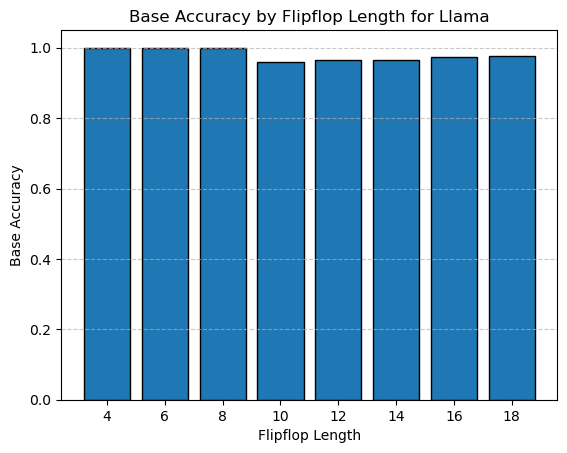

In [119]:
lengths = []
base_accuracies = []
for length in llama_flipflops.keys():
    acc = get_base_accuracy(llama_flipflops[length])
    print(f"Base accuracy for flipflop of length {length} is {acc}")
    lengths.append(length)
    base_accuracies.append(acc)

plt.bar(lengths, base_accuracies, width=0.8, align='center', edgecolor='black')
plt.xlabel("Flipflop Length")
plt.ylabel("Base Accuracy")
plt.title("Base Accuracy by Flipflop Length for Llama")
plt.xticks(lengths) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Base accuracy for OLMo Flipflops

Base accuracy for flipflop of length 4 is 0.5
Base accuracy for flipflop of length 6 is 0.75
Base accuracy for flipflop of length 8 is 0.7352941176470589
Base accuracy for flipflop of length 10 is 0.6824324324324325
Base accuracy for flipflop of length 12 is 0.6553846153846153
Base accuracy for flipflop of length 14 is 0.6501396648044693
Base accuracy for flipflop of length 16 is 0.6325787557384834
Base accuracy for flipflop of length 18 is 0.6180859459071669


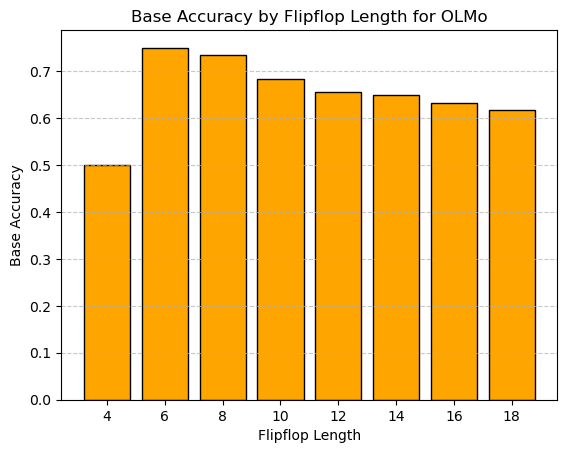

In [120]:
lengths = []
base_accuracies = []
for length in olmo_flipflops.keys():
    acc = get_base_accuracy(olmo_flipflops[length])
    print(f"Base accuracy for flipflop of length {length} is {acc}")
    lengths.append(length)
    base_accuracies.append(acc)

plt.bar(lengths, base_accuracies, width=0.8, align='center', edgecolor='black', color='orange')
plt.xlabel("Flipflop Length")
plt.ylabel("Base Accuracy")
plt.title("Base Accuracy by Flipflop Length for OLMo")
plt.xticks(lengths) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Per digit accuracy for Llama Flipflops - digit 0

In [121]:
length_0 = []
acc_0 = []
for length in llama_flipflops.keys():
    acc = get_digit_accuracy(llama_flipflops[length], 0)
    print(f"Digit accuracy for flipflop of length {length} is {acc}")
    acc_0.append(acc)
    length_0.append(0)

Digit accuracy for flipflop of length 4 is 1.0
Digit accuracy for flipflop of length 6 is 1.0
Digit accuracy for flipflop of length 8 is 1.0
Digit accuracy for flipflop of length 10 is 0.9594594594594594
Digit accuracy for flipflop of length 12 is 0.9723076923076923
Digit accuracy for flipflop of length 14 is 0.9650837988826816
Digit accuracy for flipflop of length 16 is 0.9692892195662498
Digit accuracy for flipflop of length 18 is 0.9685056316808953


## Per digit accuracy for Llama Flipflops - digit 1

In [122]:
length_1 = []
acc_1 = []
for length in llama_flipflops.keys():
    acc = get_digit_accuracy(llama_flipflops[length], 1)
    print(f"Digit accuracy for flipflop of length {length} is {acc}")
    acc_1.append(acc)
    length_1.append(length)

Digit accuracy for flipflop of length 4 is 1.0
Digit accuracy for flipflop of length 6 is 1.0
Digit accuracy for flipflop of length 8 is 1.0
Digit accuracy for flipflop of length 10 is 0.9594594594594594
Digit accuracy for flipflop of length 12 is 0.96
Digit accuracy for flipflop of length 14 is 0.9664804469273743
Digit accuracy for flipflop of length 16 is 0.9772043691625771
Digit accuracy for flipflop of length 18 is 0.9828179926824019


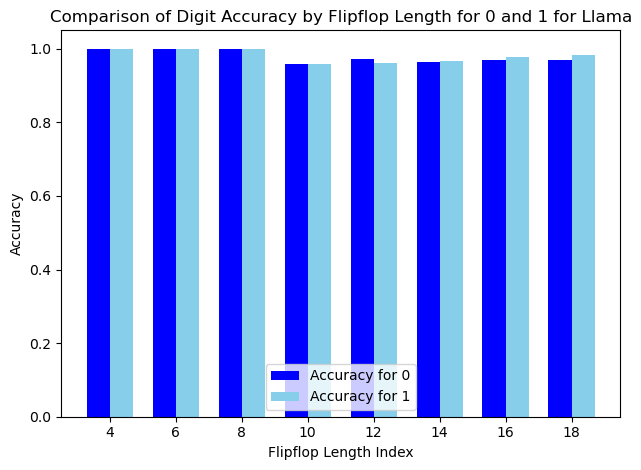

In [123]:
bar_width = 0.35

indices = np.arange(len(length_1))

plt.bar(indices - bar_width / 2, acc_0, bar_width, label="Accuracy for 0", color='blue')
plt.bar(indices + bar_width / 2, acc_1, bar_width, label="Accuracy for 1", color='skyblue')

plt.xlabel("Flipflop Length Index")
plt.ylabel("Accuracy")
plt.title("Comparison of Digit Accuracy by Flipflop Length for 0 and 1 for Llama")
plt.xticks(indices, length_1) 
plt.legend()

plt.tight_layout()
plt.show()

## Per digit accuracy for OLMo Flipflops - digit 0

In [124]:
length_0 = []
acc_0 = []
for length in olmo_flipflops.keys():
    acc = get_digit_accuracy(olmo_flipflops[length], 0)
    print(f"Digit accuracy for flipflop of length {length} is {acc}")
    acc_0.append(acc)
    length_0.append(0)

Digit accuracy for flipflop of length 4 is 1.0
Digit accuracy for flipflop of length 6 is 1.0
Digit accuracy for flipflop of length 8 is 0.9411764705882353
Digit accuracy for flipflop of length 10 is 0.9459459459459459
Digit accuracy for flipflop of length 12 is 0.9353846153846154
Digit accuracy for flipflop of length 14 is 0.9455307262569832
Digit accuracy for flipflop of length 16 is 0.9637486148488207
Digit accuracy for flipflop of length 18 is 0.9658870794174618


## Per digit accuracy for OLMo Flipflops - digit 1

In [125]:
length_1 = []
acc_1 = []
for length in olmo_flipflops.keys():
    acc = get_digit_accuracy(olmo_flipflops[length], 1)
    print(f"Digit accuracy for flipflop of length {length} is {acc}")
    acc_1.append(acc)
    length_1.append(length)

Digit accuracy for flipflop of length 4 is 0.0
Digit accuracy for flipflop of length 6 is 0.5
Digit accuracy for flipflop of length 8 is 0.5294117647058824
Digit accuracy for flipflop of length 10 is 0.4189189189189189
Digit accuracy for flipflop of length 12 is 0.37538461538461537
Digit accuracy for flipflop of length 14 is 0.3547486033519553
Digit accuracy for flipflop of length 16 is 0.3014088966281463
Digit accuracy for flipflop of length 18 is 0.2702848123968721


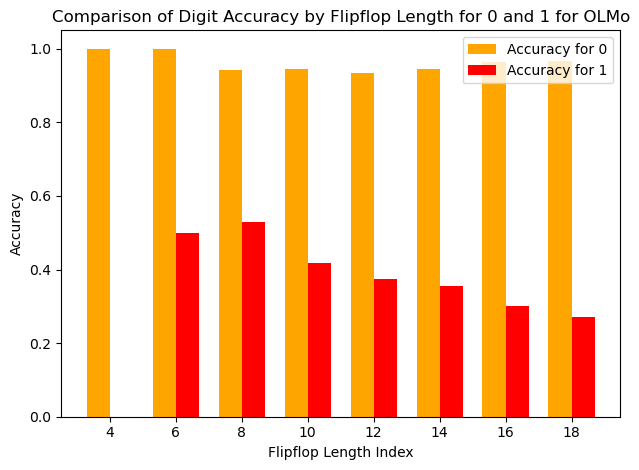

In [126]:
bar_width = 0.35

indices = np.arange(len(length_1))

plt.bar(indices - bar_width / 2, acc_0, bar_width, label="Accuracy for 0", color='orange')
plt.bar(indices + bar_width / 2, acc_1, bar_width, label="Accuracy for 1", color='red')

plt.xlabel("Flipflop Length Index")
plt.ylabel("Accuracy")
plt.title("Comparison of Digit Accuracy by Flipflop Length for 0 and 1 for OLMo")
plt.xticks(indices, length_1) 
plt.legend()

plt.tight_layout()
plt.show()

## Per distance to last write for Llama Flipflops

For distance 4 the accuracy is 0.9645085803432137
For distance 6 the accuracy is 0.9662326056427933
For distance 8 the accuracy is 0.9768361581920904
For distance 10 the accuracy is 0.9824561403508771
For distance 12 the accuracy is 0.9893004115226337
For distance 14 the accuracy is 0.9861845972957084
For distance 16 the accuracy is 1.0
For distance 18 the accuracy is 0.9995427526291724


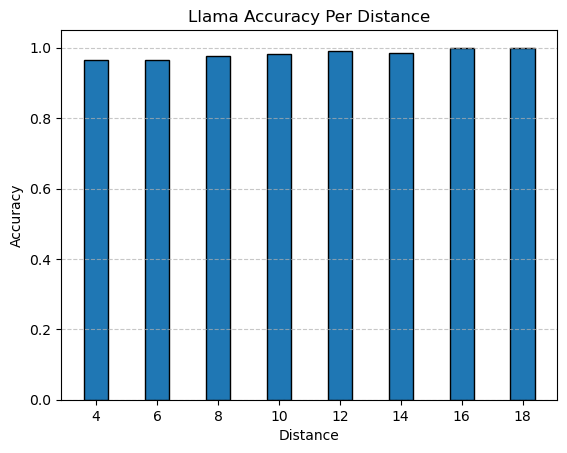

In [127]:
llama_per_distance = get_per_dist_accuracy(llama_to_18)
for dist, acc in llama_per_distance.items():
    print(f"For distance {dist} the accuracy is {acc}")

distances = list(llama_per_distance.keys())
accuracies = list(llama_per_distance.values())

plt.bar(distances, accuracies, width=0.8, align='center', edgecolor='black')
plt.xlabel("Distance")
plt.ylabel("Accuracy")
plt.title("Llama Accuracy Per Distance")
plt.xticks(distances) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Per distance to last write for OLMo Flipflops

For distance 4 the accuracy is 0.6414889928930491
For distance 6 the accuracy is 0.6432401378782076
For distance 8 the accuracy is 0.6386064030131827
For distance 10 the accuracy is 0.6189083820662769
For distance 12 the accuracy is 0.5845679012345679
For distance 14 the accuracy is 0.5376249265138154
For distance 16 the accuracy is 0.5480109739368999
For distance 18 the accuracy is 0.571787837219936


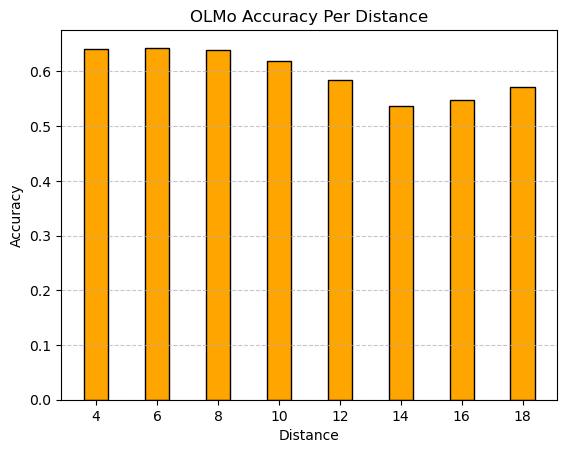

In [128]:
olmo_per_distance = get_per_dist_accuracy(olmo_to_18)
for dist, acc in olmo_per_distance.items():
    print(f"For distance {dist} the accuracy is {acc}")

distances_olmo = list(olmo_per_distance.keys())
accuracies_olmo = list(olmo_per_distance.values())

plt.bar(distances_olmo, accuracies_olmo, width=0.8, align='center', edgecolor='black', color='orange')
plt.xlabel("Distance")
plt.ylabel("Accuracy")
plt.title("OLMo Accuracy Per Distance")
plt.xticks(distances_olmo)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()